<a href="https://colab.research.google.com/github/GIJOE1003/3103ETF/blob/main/Notebook2_Signal_Classification_3rd_April_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ETF Signal Classification

This notebook classifies ETF future returns into Buy / Hold / Sell signals using multiple classification models.

In [12]:

import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


## Data Collection

In [13]:

# Data Collection
tickers = ['SPY', 'QQQ', 'GLD','TLT', 'VTI','EEM','XLF','XLV','VEA','VNQ']
end_date = pd.to_datetime('today')
start_date = end_date - pd.DateOffset(months=120)

# Download prices
df_raw = yf.download(tickers, start=start_date, end=end_date)

df_open = df_raw['Open'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Open')
df_close = df_raw['Close'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Close')
df_high  = df_raw['High'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='High')
df_low   = df_raw['Low'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Low')
df_volume = df_raw['Volume'].reset_index().melt(id_vars='Date', var_name='Ticker', value_name='Volume')

# Merge into one DataFrame
df = df_open.merge(df_close, on=['Date', 'Ticker']).merge(df_high, on=['Date', 'Ticker']).merge(df_low, on=['Date', 'Ticker']).merge(df_volume, on=['Date', 'Ticker'])
df = df.round(2)

# Create CSV File
df.to_csv("combined_etf_data.csv", index = False)
print(f"Combined data saved: {df.shape}")
print(df.head())
print(df.tail())

df.isnull().sum()
df.info()


[*********************100%***********************]  10 of 10 completed


Combined data saved: (25170, 7)
        Date Ticker   Open  Close   High    Low    Volume
0 2015-04-10    EEM  34.21  34.38  34.39  34.18  49899000
1 2015-04-13    EEM  34.45  34.18  34.57  34.17  55031100
2 2015-04-14    EEM  34.26  34.34  34.41  34.11  42601100
3 2015-04-15    EEM  34.33  34.58  34.59  34.26  40254700
4 2015-04-16    EEM  34.67  34.85  35.05  34.62  55057700
            Date Ticker    Open   Close    High     Low    Volume
25165 2025-04-04    XLV  141.14  135.28  141.71  135.23  21341100
25166 2025-04-07    XLV  131.71  134.47  137.37  129.66  29940300
25167 2025-04-08    XLV  139.43  132.98  139.44  131.28  20860400
25168 2025-04-09    XLV  130.13  138.76  139.24  129.68  39441700
25169 2025-04-10    XLV  137.70  131.85  137.74  131.82   8188139
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25170 entries, 0 to 25169
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    25170 non-null 

## Feature Engineering and Signal Generation

In [14]:
df['Return'] = df.groupby('Ticker')['Close'].pct_change().round(4)
df['Return'] = df['Return'].fillna(0.0)
df['Volatility7'] = df.groupby('Ticker')['Return'].rolling(window=20).std().reset_index(level=0, drop=True).round(4)
df['Volatility7'] = df['Volatility7'].fillna(0.0)


df['MA5'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(20).mean()).round(4)
df['Close_MA5_diff'] = ((df['Close'] - df['MA5']) / df['MA5'] * 100).round(4)

windows = [20, 50, 200]
for w in windows:
    df[f'SMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(w).mean()).round(4)
    df[f'EMA{w}'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=w, adjust=False).mean()).round(4)


df['PrevClose'] = df.groupby('Ticker')['Close'].shift(1)
df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)
df['ATR7'] = df.groupby('Ticker')['TR'].transform(lambda x: x.rolling(7).mean()).round(4)
df['ATR7_pct'] = (df['ATR7'] / df['Close'] * 100).round(4)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)

ema_12 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema_26 = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

df['MACD'] = (ema_12 - ema_26).round(4)
df['Signal_Line'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean()).round(4)

low14 = df.groupby('Ticker')['Low'].transform(lambda x: x.rolling(14).min())
high14 = df.groupby('Ticker')['High'].transform(lambda x: x.rolling(14).max())

df['%K'] = ((df['Close'] - low14) / (high14 - low14) * 100).round(2)
df['%D'] = df.groupby('Ticker')['%K'].transform(lambda x: x.rolling(3).mean())

df['DayOfWeek'] = pd.to_datetime(df['Date']).dt.dayofweek
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['IsMonthEnd'] = pd.to_datetime(df['Date']).dt.is_month_end.astype(int)


df.to_csv("combined_etf_data_features.csv", index = False)
print(f"Combined data saved: {df.shape}")

<ipython-input-14-c7f3bfe94bce>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['TR'] = df[['High', 'Low', 'PrevClose']].apply(lambda x: max(x[0]-x[1], abs(x[0]-x[2]), abs(x[1]-x[2])), axis=1).round(4)


Combined data saved: (25170, 29)


In [15]:

# Basic features
df['Return'] = df.groupby('Ticker')['Close'].pct_change()
df['Future_Close'] = df.groupby('Ticker')['Close'].shift(-7)
df['Predicted_Return'] = (df['Future_Close'] - df['Close']) / df['Close']
df['Signal'] = df['Predicted_Return'].apply(lambda x: 1 if x > 0.01 else -1 if x < -0.010 else 0)
df.dropna(inplace=True)

features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7','RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']
X = df[features]
y = df['Signal']

y_xgb = y.replace({-1: 0, 0: 1, 1: 2})

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)
_, _, y_train_xgb, y_test_xgb = train_test_split(X_scaled, y_xgb, test_size=0.2, shuffle=False)


### Logistic Regression

Logistic Regression - Train Metrics
              precision    recall  f1-score   support

          -1       0.32      0.31      0.31      4982
           0       0.41      0.61      0.49      6152
           1       0.48      0.31      0.37      7354

    accuracy                           0.41     18488
   macro avg       0.41      0.41      0.39     18488
weighted avg       0.42      0.41      0.40     18488



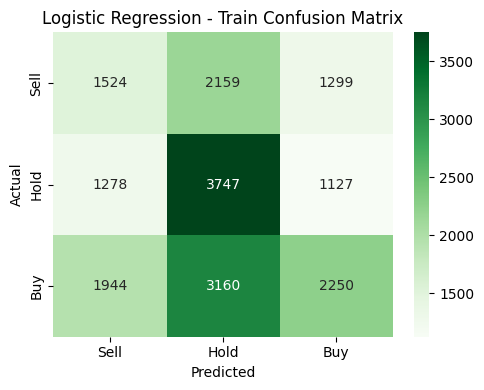


 Logistic Regression - Test Metrics
              precision    recall  f1-score   support

          -1       0.31      0.31      0.31      1249
           0       0.38      0.58      0.46      1468
           1       0.50      0.31      0.38      1905

    accuracy                           0.39      4622
   macro avg       0.40      0.40      0.38      4622
weighted avg       0.41      0.39      0.39      4622



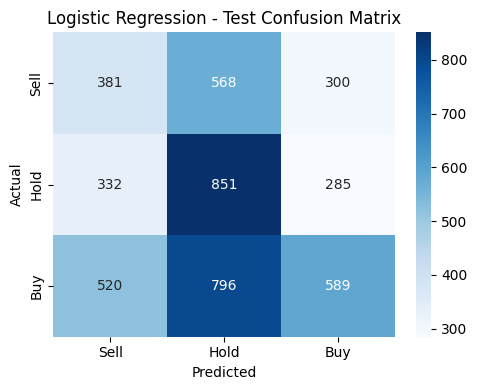

In [23]:
# Train model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Train Evaluation
y_train_pred = log_reg.predict(X_train)
print("Logistic Regression - Train Metrics")
print(classification_report(y_train, y_train_pred))

cm_train = confusion_matrix(y_train, y_train_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm_train, annot=True, fmt='d', cmap="Greens", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Logistic Regression - Train Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# Test Evaluation
y_pred = log_reg.predict(X_test)
print("\n Logistic Regression - Test Metrics")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Logistic Regression - Test Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### Random Forest Classifier

Random Forest
               precision    recall  f1-score   support

          -1       0.29      0.17      0.22      1249
           0       0.37      0.24      0.29      1468
           1       0.43      0.65      0.52      1905

    accuracy                           0.39      4622
   macro avg       0.36      0.36      0.34      4622
weighted avg       0.37      0.39      0.36      4622



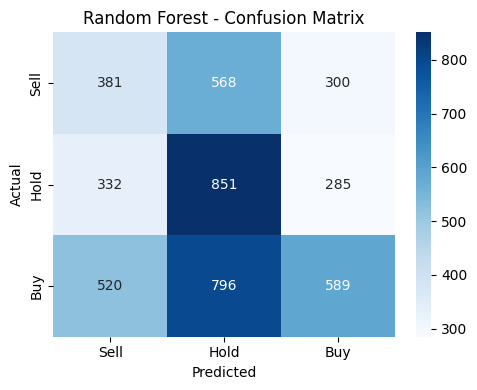

In [17]:

rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest\n", classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


### XGBoost Classifier

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:22:23] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost
               precision    recall  f1-score   support

   Sell (-1)       0.28      0.18      0.22      1249
    Hold (0)       0.35      0.25      0.29      1468
     Buy (1)       0.43      0.63      0.51      1905

    accuracy                           0.39      4622
   macro avg       0.35      0.35      0.34      4622
weighted avg       0.36      0.39      0.36      4622

18488 18488


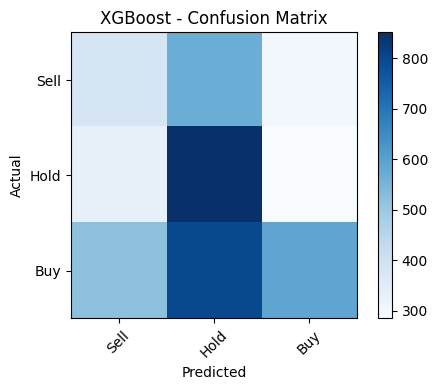

In [18]:
# For XGBoost only: remap -1 → 0, 0 → 1, 1 → 2


xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_xgb)
y_pred_xgb_raw = xgb_model.predict(X_test)
y_pred_final = pd.Series(y_pred_xgb_raw).replace({0: -1, 1: 0, 2: 1})
print("XGBoost\n", classification_report(y_test, y_pred_final,target_names=["Sell (-1)", "Hold (0)", "Buy (1)"]))
print(len(X_train), len(y_train_xgb))

cm_xgb = confusion_matrix(y_test, y_pred_final, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("XGBoost - Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len([-1, 0, 1]))
plt.xticks(tick_marks, ["Sell", "Hold", "Buy"], rotation=45)
plt.yticks(tick_marks, ["Sell", "Hold", "Buy"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()



### MLP Classifier

MLP Classifier
               precision    recall  f1-score   support

          -1       0.29      0.34      0.31      1249
           0       0.37      0.23      0.29      1468
           1       0.45      0.53      0.49      1905

    accuracy                           0.38      4622
   macro avg       0.37      0.37      0.36      4622
weighted avg       0.38      0.38      0.38      4622



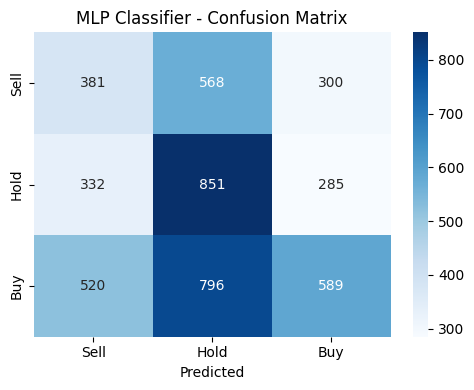

In [19]:

mlp_model = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=500)
mlp_model.fit(X_train, y_train)
y_pred_mlp = mlp_model.predict(X_test)
print("MLP Classifier\n", classification_report(y_test, y_pred_mlp))

cm_mlp = confusion_matrix(y_test, y_pred_mlp, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("MLP Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel
plt.tight_layout()
plt.show()


### LSTM Classifier

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3984 - loss: 1.0914 - val_accuracy: 0.4407 - val_loss: 1.0786
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.3907 - loss: 1.0878 - val_accuracy: 0.4407 - val_loss: 1.0795
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3906 - loss: 1.0889 - val_accuracy: 0.4407 - val_loss: 1.0727
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3910 - loss: 1.0893 - val_accuracy: 0.4407 - val_loss: 1.0750
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3932 - loss: 1.0877 - val_accuracy: 0.4407 - val_loss: 1.0773
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3949 - loss: 1.0875 - val_accuracy: 0.3079 - val_loss: 1.0872
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3939 - loss: 1.0844 - val_accuracy: 0.4407 - val_loss: 1.0749
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.3932 - loss: 1.0880 - val_accuracy: 0.4407 - val_

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


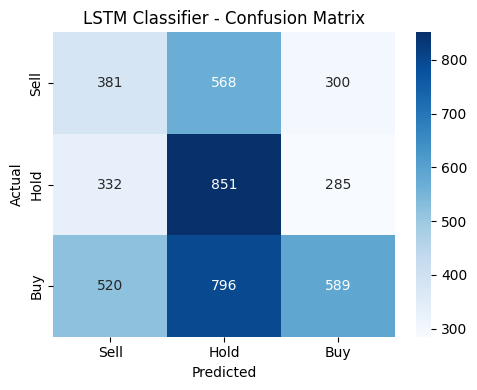

In [20]:

# LSTM expects 3D input
def create_lstm_sequences(data, labels, lookback=7):
    X_lstm, y_lstm = [], []
    for ticker in data['Ticker'].unique():
        df_ticker = data[data['Ticker'] == ticker].reset_index(drop=True)
        for i in range(lookback, len(df_ticker) - 7):
            X_lstm.append(df_ticker[features].iloc[i-lookback:i].values)
            y_lstm.append(df_ticker['Signal'].iloc[i])
    return np.array(X_lstm), np.array(y_lstm)

X_lstm, y_lstm = create_lstm_sequences(df, df['Signal'])
y_lstm_cat = to_categorical(y_lstm + 1, num_classes=3)

X_train_lstm, X_test_lstm = X_lstm[:int(0.8*len(X_lstm))], X_lstm[int(0.8*len(X_lstm)):]
y_train_lstm, y_test_lstm = y_lstm_cat[:int(0.8*len(y_lstm))], y_lstm[int(0.8*len(y_lstm)):]

lstm_cls = Sequential([
    LSTM(64, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dense(3, activation='softmax')
])
lstm_cls.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_cls.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.1)
y_pred_lstm_raw = lstm_cls.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_raw, axis=1) - 1

print("LSTM Classifier\n", classification_report(y_test_lstm, y_pred_lstm))

cm_lstm = confusion_matrix(y_test_lstm, y_pred_lstm, labels=[-1, 0, 1])
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Sell", "Hold", "Buy"], yticklabels=["Sell", "Hold", "Buy"])
plt.title("LSTM Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score # Import recall_score and precision_score

summary = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'MLP Classifier', 'LSTM Classifier'],
    'Accuracy': [accuracy_score(y_test, y_pred), accuracy_score(y_test, y_pred_rf ), accuracy_score(y_test, y_pred_final), accuracy_score(y_test, y_pred_mlp), accuracy_score(y_test_lstm, y_pred_lstm)],
    'F1 Score': [f1_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred_rf, average='weighted'), f1_score(y_test, y_pred_final, average='weighted'), f1_score(y_test, y_pred_mlp, average='weighted'), f1_score(y_test_lstm, y_pred_lstm, average='weighted')],
    'Recall': [recall_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred_rf, average='weighted'), recall_score(y_test, y_pred_final, average='weighted'), recall_score(y_test, y_pred_mlp, average='weighted'), recall_score(y_test_lstm, y_pred_lstm, average='weighted')],
    'Precision': [precision_score(y_test, y_pred, average='weighted'), precision_score(y_test, y_pred_rf, average='weighted'), precision_score(y_test, y_pred_final, average='weighted'), precision_score(y_test, y_pred_mlp, average='weighted'), precision_score(y_test_lstm, y_pred_lstm, average='weighted')],
    'Confusion Matrix': [cm, cm_rf, cm_xgb, cm_mlp, cm_lstm]
})

print(summary)





                 Model  Accuracy  F1 Score    Recall  Precision  \
0  Logistic Regression  0.393985  0.387428  0.393985   0.412309   
1        Random Forest  0.392904  0.364176  0.392904   0.371417   
2              XGBoost  0.385764  0.361835  0.385764   0.364492   
3       MLP Classifier  0.384682  0.376624  0.384682   0.382269   
4      LSTM Classifier  0.414671  0.243099  0.414671   0.171952   

                                    Confusion Matrix  
0  [[381, 568, 300], [332, 851, 285], [520, 796, ...  
1  [[217, 246, 786], [232, 353, 883], [295, 364, ...  
2  [[228, 273, 748], [266, 363, 839], [318, 395, ...  
3  [[422, 240, 587], [469, 344, 655], [553, 340, ...  
4         [[0, 0, 1225], [0, 0, 1464], [0, 0, 1905]]  


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import joblib

#  Load data (
latest_df = df.groupby("Ticker").tail(1).copy().reset_index(drop=True)

# Repeat
future_days = []
today = pd.to_datetime(datetime.today().date())
while len(future_days) < 7:
    today += timedelta(days=1)
    if today.weekday() < 5:
        future_days.append(today)

# Repeat data
future_df = pd.DataFrame(np.repeat(latest_df.values, len(future_days), axis=0), columns=latest_df.columns)
future_df["Date"] = future_days * len(latest_df)

# scale features
features = ['High', 'Low', 'Volume','Return',
    'MA5', 'Close_MA5_diff', 'SMA20', 'EMA20','Volatility7',
    'SMA50', 'EMA50', 'SMA200', 'EMA200', 'TR', 'ATR7',
    'RSI14','MACD','Signal_Line','%K','%D','DayOfWeek','Month','IsMonthEnd']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[features])  # fit on full dataset
X_future = scaler.transform(future_df[features])

# Train MLP Classifier
mlp_model = MLPClassifier(hidden_layer_sizes=(64,), max_iter=300, random_state=42)
mlp_model.fit(X_scaled, df['Signal'])  # You can also load a saved model with joblib

# Predict
predicted_signals = mlp_model.predict(X_future)

# results
future_df['Predicted_Signal'] = predicted_signals
final_output = future_df[['Ticker', 'Date', 'Predicted_Signal']].sort_values(['Ticker', 'Date'])

#  Map signals to labels
signal_map = {-1: "Sell", 0: "Hold", 1: "Buy"}
final_output['Signal_Label'] = final_output['Predicted_Signal'].map(signal_map)

# Export ---
print(final_output)

final_output.to_csv("future_7day_signals.csv", index=False)


   Ticker       Date  Predicted_Signal Signal_Label
0     EEM 2025-04-11                 1          Buy
1     EEM 2025-04-14                 1          Buy
2     EEM 2025-04-15                 1          Buy
3     EEM 2025-04-16                 1          Buy
4     EEM 2025-04-17                 1          Buy
..    ...        ...               ...          ...
65    XLV 2025-04-15                 1          Buy
66    XLV 2025-04-16                 1          Buy
67    XLV 2025-04-17                 1          Buy
68    XLV 2025-04-18                 1          Buy
69    XLV 2025-04-21                 1          Buy

[70 rows x 4 columns]
